<a href="https://colab.research.google.com/github/welovecherry/00-AI-Study/blob/main/06_machine_learning/%5BML_Basic%5D_(5_4)_%E1%84%92%E1%85%A7%E1%86%B8%E1%84%8B%E1%85%A5%E1%86%B8_%E1%84%91%E1%85%B5%E1%86%AF%E1%84%90%E1%85%A5%E1%84%85%E1%85%B5%E1%86%BC%E1%84%8B%E1%85%B3%E1%86%AF_%E1%84%92%E1%85%AA%E1%86%AF%E1%84%8B%E1%85%AD%E1%86%BC%E1%84%92%E1%85%A1%E1%86%AB_%E1%84%91%E1%85%A7%E1%86%BC%E1%84%8C%E1%85%A5%E1%86%B7_%E1%84%8B%E1%85%A8%E1%84%8E%E1%85%B3%E1%86%A8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 협업 필터링을 활용한 평점 예측


## 실습 개요

1) **실습 목적**

이번 실습은, 협업 필터링 방식으로 동작하는 추천시스템을 직접 구현해보며 협업필터링 방식의
추천시스템이 동작하는 원리에 대해 좀더 이해도를 높이는 것을 목표로 합니다.



2) **수강 목표**

- 주어진 유저의 평가 데이터를 전처리해 유저-아이템 선호도 행렬의 형태로 변환할 수 있다.
- 메모리 기반 협업 필터링이 동작하는 방식을 이해한다.
- 주어진 행렬에 Truncated SVD을 적용해 빈 값을 채워넣는 방식을 이해한다.

### 목차

* 1. 실습 데이터셋 준비
  * 1-1. 데이터셋을 불러와 전처리
  * 1-2. 평점 데이터셋 정보 파악
* 2. 메모리 기반의 협업 필터링
  * 2-1. 유저-아이템 선호도 행렬
  * 2-2. 콘텐츠 기반의 협업 필터링
  * 2-3. 사용자 기반의 협업 필터링
* 3. 잠재요인 기반의 협업 필터링
  * 3-1. SVD 행렬분해
  * 3-2. SVD 행렬분해를 활용한 평점 예측


### 환경설정


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 협업 필터링 구현에 필요한 패키지
from scipy.sparse.linalg import svds
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD


###  데이터셋 개요

* 데이터셋: The Movies Dataset
* 데이터셋 개요: 2017년 7월 이전에 개봉한 약 45,000편의 영화들에 대해 제작비, 캐스팅 등 여러
정보(메타데이터)와 함께, 유저가 1~5점 스케일로 작성한 영화에 대한 평가점수 정보를 포함하는 데이터셋입니다.
* 데이터셋 저작권 : CC0 Public Domain


## 1. 실습 데이터셋 준비

```
💡 목차 개요 : 데이터셋을 다운로드해 코랩에 업로드하고, 기본적인 정보들을 파악해봅니다.
```



### 1-1. 데이터셋을 불러와 전처리

#### 📝 설명 : The Movies Dataset


[Kaggle Dataset page](https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset/data)

2017년 7월
이전 개봉한 45000편의 영화에 대한 메타데이터(캐스팅, 제작비, 수익, 개봉일 등등)와 영화에 대한 평가를
남길수 있는 [MovieLens](https://movielens.org/) 서비스에서 수집된 평점 정보를 수집한
데이터셋입니다.

이 실습에서 사용할 small 버전의 평점 데이터셋은 700명의 유저가 약 9000개의 영화에
대해 작성한 10만건의 평점 데이터로 구성되어 있습니다.



캐글 데이터셋 페이지에서
- `ratings_small.csv`
- `movies_metadata.csv`

두개 파일을 다운로드해 colab의 런타임에 업로드합니다.
업로드는 코랩 화면 왼쪽의 "파일"탭에서 수행할 수 있습니다.

업로드를 완료한 후, pandas 패키지의 `read_csv`함수를 사용해 다음과 같이 데이터를 읽어옵니다.

In [ ]:
rating_data = pd.read_csv('/content/ratings_small.csv')
movie_data = pd.read_csv('/content/movies_metadata.csv')

<ipython-input-29-0e40e81cc091>:2: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  movie_data = pd.read_csv('/content/movies_metadata.csv')


#### 📝 설명 : ratings.csv 파일

- userId
- movieId
- rating
- timestamp

이렇게 4개 형태의 변수를 저장하고 있습니다.
각 유저(`userId`)가 본 영화(`movieId`)에 대해서 5.0점을 만점으로 평가한 점수 데이터(`rating`)가 시간(`timestamp`)과 함께 저장되어 있습니다.

In [ ]:
rating_data

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205
...,...,...,...,...
99999,671,6268,2.5,1065579370
100000,671,6269,4.0,1065149201
100001,671,6365,4.0,1070940363
100002,671,6385,2.5,1070979663


timestamp가 매우 큰 정수 형태로 되어있는 것이 눈에 띄는데, 이는 기준시점 (1980년 1월 1일 0시
00분)을 기준으로 경과한 시간을 초 단위로 나타낸 것입니다. 이 실습에서 timestamp정보는 사용하지
않으므로 신경쓸 필요는 없습니다.


#### 📝 설명 : Movie 메타데이터 파일
Movie 파일은 ratings 파일보다 훨씬 더 많은 정보를 포함하고 있습니다.
하지만, 이 실습에서는 ratings에 포함된 `movieID` 정보로부터 해당 영화가
어떤것인지를 알아보기 위한 용도로,
- `id`
- `title`

이렇게 두개의 정보만을 활용할 것입니다.


In [ ]:
movie_data

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45461,False,NaN,0,"[{'id': 18, 'name': 'Drama'}, {'id': 10751, 'n...",http://www.imdb.com/title/tt6209470/,439050,tt6209470,fa,رگ خواب,Rising and falling between a man and woman.,...,NaN,0.0,90.0,"[{'iso_639_1': 'fa', 'name': 'فارسی'}]",Released,Rising and falling between a man and woman,Subdue,False,4.0,1.0
45462,False,NaN,0,"[{'id': 18, 'name': 'Drama'}]",NaN,111109,tt2028550,tl,Siglo ng Pagluluwal,An artist struggles to finish his work while a...,...,2011-11-17,0.0,360.0,"[{'iso_639_1': 'tl', 'name': ''}]",Released,NaN,Century of Birthing,False,9.0,3.0
45463,False,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...",NaN,67758,tt0303758,en,Betrayal,"When one of her hits goes wrong, a professiona...",...,2003-08-01,0.0,90.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A deadly game of wits.,Betrayal,False,3.8,6.0
45464,False,NaN,0,[],NaN,227506,tt0008536,en,Satana likuyushchiy,"In a small town live two brothers, one a minis...",...,1917-10-21,0.0,87.0,[],Released,NaN,Satan Triumphant,False,0.0,0.0



#### 👨‍💻 코드 : 영화의 id, title간 변환을 위한 dictionary생성
- id를 통해 타이틀을 찾을 수 있도록, 영화 메타데이터에서 id, 타이틀 정보만 선택하여 dictionary형태로 변형
- 위 dict의 key, value를 뒤집어 별도의 dict로 생성

In [ ]:
# 빈 영화 메타데이터의 id에 title을 대응시키는 dict 생성
id_to_title = {row['id']: row['title'] for _, row in movie_data[['id', 'title']].iterrows()}
print(id_to_title['862'])

Toy Story


In [ ]:
title_to_id = {v: k for k, v in id_to_title.items()}
print(title_to_id['Iron Man'])

194310


### 1-2. 평점 데이터셋 정보 파악

> 협업필터링 방식의 추천시스템을 만드는데 사용할 평점 데이터의 정보를 파악해봅니다.


#### 👨‍💻 코드 : 영화별 받은 평점 수 분포 시각화
- `pandas` 패키지의 groupby기능을 활용해 영화별 평점 수 확인
- 히스토그램 형태로 시각화

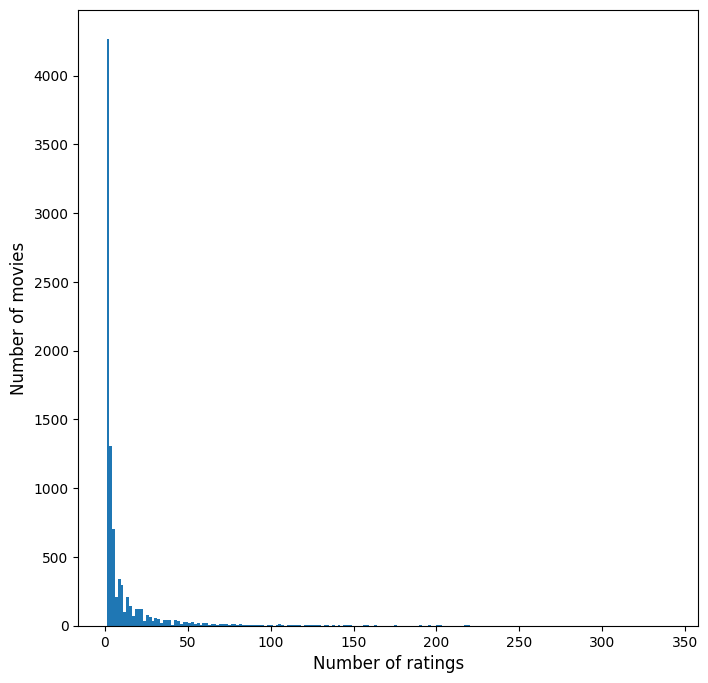

In [ ]:
# 유저 평점 데이터들 중 동일한 movieId를 가진 샘플들을 묶어(groupby) 각 영화에 대한 평점이 몇개인지 확인
movie_rating_count = rating_data.groupby('movieId')['rating'].count()

# 히스토그램 시각화
plt.figure(figsize=(8, 8))
fig = plt.hist(movie_rating_count, bins=200)
plt.ylabel('Number of movies', fontsize=12)
plt.xlabel('Number of ratings', fontsize=12)
plt.show()

히스토그램 확인 결과 영화별 받은 평점 개수의 분포가 매우 심한 long-tailed 분포를 보이는 것을 확인할 수 있습니다.
전체 영화 중에서 10개, 100개 이상의 평점을 받은 데이터가 얼마나 있는지도 파악해보도록 하겠습니다.

In [ ]:
print("평점 데이터 내에 있는 총 영화 수 :", len(rating_data['movieId'].unique()))
print("10개 이상의 평점을 받은 영화 수 :", len(movie_rating_count[movie_rating_count >= 10]))
print("100개 이상의 평점을 받은 영화 수 :", len(movie_rating_count[movie_rating_count >= 100]))

평점 데이터 내에 있는 총 영화 수 : 9066
10개 이상의 평점을 받은 영화 수 : 2245
100개 이상의 평점을 받은 영화 수 : 151



#### 👨‍💻 코드 : 영화별 평균 평점의 분포 확인
- `pandas`의 `groupby`기능을 활용해 영화별 평가점수 평균값 확인
- 영화별 평점 평균값 분포 시각화
- 10개 이상의 평가를 받은 영화들 중 평균 rating이 가장 높은 영화 확인

In [ ]:
# 영화별 받은 평가의 수 / 평균 점수를 각각 첫번째, 두번째 column으로 하는 데이터를 생성
movie_rating_info = rating_data.groupby("movieId")['rating'].agg(['count', 'mean'])
movie_rating_info.columns = ['rated_count', 'rating_mean']
movie_rating_info

,rated_count,rating_mean
movieId,,
1,247,3.872470
2,107,3.401869
3,59,3.161017
4,13,2.384615
5,56,3.267857
...,...,...
161944,1,5.000000
162376,1,4.500000
162542,1,5.000000


<Axes: >

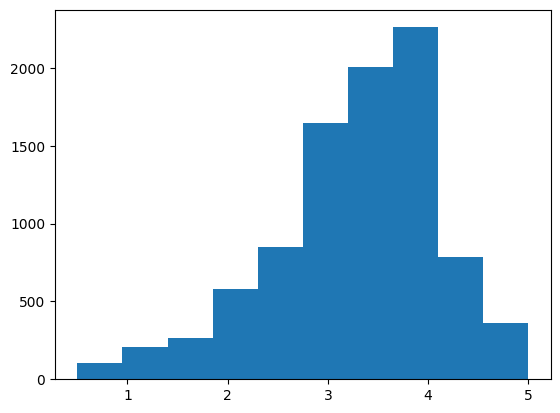

In [ ]:
# 영화별 평가점수 분포 확인
movie_rating_info['rating_mean'].hist(grid=False)


#### 👨‍💻 코드 : 높은 평점을 받은 영화 확인
- 충분한(100개 이상) 평가를 받은 영화들 중 평균 평점이 높은 영화들의 id를 확인
- 확인한 고평점 영화 id에 해당하는 영화 제목을 확인해 출력

In [ ]:
# 100번 이상의 평가를 받은 영화 중, 평점이 높은 10개의 영화를 출력합니다.
indices_enough_eval = movie_rating_info['rated_count'] > 100

# 평가 수가 100개 이상인 영화들만 선택 후 최고 평점인 10개 영화의 id확인
top_10_movies = movie_rating_info[indices_enough_eval].nlargest(10, 'rating_mean')
top_10_movies

,rated_count,rating_mean
movieId,,
858,200,4.487500
318,311,4.487138
1221,135,4.385185
50,201,4.370647
527,244,4.303279
1193,144,4.256944
608,224,4.256696
296,324,4.256173
2858,220,4.236364


In [ ]:
for movie_id, (count, score) in top_10_movies.iterrows():
    try:
        # 영화 메타데이터 내에 해당 id의 영화가 있다면 타이틀을 출력
        title = id_to_title[str(movie_id)]
    except KeyError:
        # 없다면 영화 id를 그대로 출력
        title = f'unknown movie id: {movie_id}'

    # 제목과 받은 평점, 평가 수를 함께 출력
    print(f'{title}, score: {score:.03}, count: {int(count)}')

Sleepless in Seattle, score: 4.49, count: 200
The Million Dollar Hotel, score: 4.49, count: 311
unknown movie id: 1221, score: 4.39, count: 135
unknown movie id: 50, score: 4.37, count: 201
Once Were Warriors, score: 4.3, count: 244
unknown movie id: 1193, score: 4.26, count: 144
Men in Black II, score: 4.26, count: 224
Terminator 3: Rise of the Machines, score: 4.26, count: 324
unknown movie id: 2858, score: 4.24, count: 220
Confession of a Child of the Century, score: 4.24, count: 121


## 2. 메모리 기반의 협업 필터링
```
💡 목차 개요 : 협업 필터링 방식의 추천시스템 방법론을 실습합니다.
```

### 2-1. 유저-아이템 선호도 행렬

> 주어진 데이터를 변형해 유저-아이템 선호도 행렬의 형태가 되도록 변환해줍니다.

#### 📝 설명 : 유저-아이템 선호도 행렬

유저-아이템 선호도 행렬은 사용자들이 아이템에 대해 표현한 선호도를 담고 있는
행렬로, 각 사용자들의 특정 아이템에 대해 표현한 선호도를 나타냅니다. 협업 필터링
방식의 추천시스템을 만들기 위해 영화 평가 점수 데이터를 유저-아이템 선호도 행렬의 형태로 바꾸어보겠습니다.

In [ ]:
rating_data

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205
...,...,...,...,...
99999,671,6268,2.5,1065579370
100000,671,6269,4.0,1065149201
100001,671,6365,4.0,1070940363
100002,671,6385,2.5,1070979663



#### 👨‍💻 코드 : 평가 데이터를 유저-아이템 선호도 행렬 형태로 변환
- rating_data에서 불필요한 timestamp값 제거
- `pandas`의 `pivot_table`기능을 활용해 유저-아이템 선호도 행렬을 생성
- 평가가 없는 빈 값들을 0으로 채우기

In [ ]:
rating_data.drop('timestamp', axis=1, inplace=True)
rating_data.head()

,userId,movieId,rating
0,1,31,2.5
1,1,1029,3.0
2,1,1061,3.0
3,1,1129,2.0
4,1,1172,4.0


In [ ]:
# pivot_table: 데이터 column 중에서 행, 열로 사용할 두개를 골라 각각을 축으로 데이터를 펼쳐두는 기능
user_movie_rating = rating_data.pivot_table('rating', index='userId', columns='movieId')
user_movie_rating

movieId,1,2,3,4,5,6,7,8,9,10,...,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
668,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
669,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# 빈 값들을 0 으로 채워주기
user_movie_rating.fillna(0, inplace=True)
user_movie_rating

movieId,1,2,3,4,5,6,7,8,9,10,...,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
668,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
669,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### 📝 설명 : 희소행렬(Sparse matrix)
위에서 생성한 유저-아이템 선호도 행렬은 대부분의 값이 0으로 비어있고, 소수의
값에만 0이 아닌 값들이 들어있는데, 이런 형태의 행렬을 **희소행렬(또는 성긴 행렬, Sparse
matrix)**이라고 합니다. 또, 이런 희소행렬에 반대되는 개념으로서 일반적인 행렬을 밀집행렬(Dense
matrix)라고 부릅니다.

주어진 데이터가 희소행렬의 경우 0인 부분은 생략하고 나머지 0이 아닌 부분의 데이터만 저장해 효율적으로
메모리를 사용하는 CSR(Compressed Sparse Column), COO(list of COOrdinates)등의 여러
효율적인 데이터포멧을 사용할 수 있고, 연산시에도 이런 포멧에 최적화된 여러 연산들을 사용하면
효율적이지만, 이 실습에서는 생략하도록 하겠습니다.


#### 📚 자료
- [성긴행렬(Sparse matrix, 위키피디아)](https://ko.wikipedia.org/wiki/%EC%84%B1%EA%B8%B4_%ED%96%89%EB%A0%AC): 희소행렬을 저장하는 CSR, COO포멧에 대해서는 한국어 위키 페이지에도 예시와 함께 잘 설명되어있습니다.

### 2-2. 콘텐츠 기반의 협업 필터링
> 유저-아이템 행렬에서 아이템별 유저 선호도 패턴을 비교해 영화간 평점의 유사도를 분석해봅니다.


#### 👨‍💻 코드 : 선호도 패턴의 비교를 통한 영화간 유사도 확인
- 사용자-영화 평점 matrix에 transpose를 취하기
- 모든 row, 영화끼리의 코사인 유사도를 계산

In [ ]:
user_ratings_matrix_T = user_movie_rating.transpose()
user_ratings_matrix_T

userId,1,2,3,4,5,6,7,8,9,10,...,662,663,664,665,666,667,668,669,670,671
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,4.0,0.0,...,0.0,4.0,3.5,0.0,0.0,0.0,0.0,0.0,4.0,5.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161944,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
162376,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
162542,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# 모든 아이템(영화) 쌍마다 코사인유사도를 계산해 행렬의 형태로 저장
item_sim = cosine_similarity(user_ratings_matrix_T, user_ratings_matrix_T)

# 생성된 유사도 행렬에 원래의 movie id정보를 추가해 다시 dataframe형태로 변환
movie_ids = user_movie_rating.columns
item_sim_df = pd.DataFrame(
    data=item_sim,
    index=movie_ids,
    columns=movie_ids
)

# 생성된 유사도 행렬 확인
print(item_sim_df.shape)
item_sim_df.head()

(9066, 9066)


movieId,1,2,3,4,5,6,7,8,9,10,...,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
movieId,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.394511,0.306516,0.133614,0.245102,0.377086,0.278629,0.063031,0.117499,0.310689,...,0.055829,0.031902,0.079755,0.079755,0.079755,0.079755,0.079755,0.0,0.0,0.055829
2,0.394511,1.000000,0.217492,0.164651,0.278476,0.222003,0.207299,0.223524,0.113669,0.418124,...,0.000000,0.055038,0.068797,0.082557,0.082557,0.137594,0.068797,0.0,0.0,0.000000
3,0.306516,0.217492,1.000000,0.177012,0.370732,0.247499,0.435648,0.127574,0.306717,0.191255,...,0.000000,0.000000,0.000000,0.116226,0.116226,0.000000,0.000000,0.0,0.0,0.000000
4,0.133614,0.164651,0.177012,1.000000,0.179556,0.072518,0.184626,0.501513,0.254630,0.111447,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
5,0.245102,0.278476,0.370732,0.179556,1.000000,0.272645,0.388476,0.194113,0.367941,0.246846,...,0.000000,0.176845,0.000000,0.117897,0.117897,0.000000,0.000000,0.0,0.0,0.000000



#### 👨‍💻 코드 : 특정 영화와 가장 비슷한 영화목록 찾기
- 선택한 영화와 가장 유사한 5개 영화를 찾아보기
- 주석처리된 부분을 사용해 랜덤한 영화를 선택

In [ ]:
# 직접 영화 제목을 지정하는 경우
movie_title = "Men in Black II"
target_movie_id = int(title_to_id[movie_title])

# # 랜덤으로 선택하는 경우
# available_ids = [movie_id for movie_id in rating_data['movieId'].unique() if str(movie_id) in id_to_title]
# target_movie_id = np.random.choice(available_ids)
# movie_title = id_to_title[str(target_movie_id)]

# 선택된 영화의 제목과 id를 출력
print("분석대상 영화: ", movie_title)
print("id: ", target_movie_id)

# (자기 자신을 제외하고) 가장 비슷한 5개 영화의 아이디를 찾기
result = item_sim_df[target_movie_id].sort_values(ascending=False)[1:6]

# 결과 출력
print("\n이 영화와 유사한 영화들: ")
for movie_id, similarity in result.items():
    try:
        # 영화 메타데이터 내에 해당 id의 영화가 있다면 타이틀을 출력
        title = id_to_title[str(movie_id)]
    except KeyError:
        # 없다면 영화 id를 그대로 출력
        title = f'unknown movie id: {movie_id}'

    print(f"{title}, 유사도: {similarity:.03}")

분석대상 영화:  Men in Black II
id:  608

이 영화와 유사한 영화들: 
Terminator 3: Rise of the Machines, 유사도: 0.583
unknown movie id: 36, 유사도: 0.543
unknown movie id: 50, 유사도: 0.542
The Talented Mr. Ripley, 유사도: 0.537
Point Break, 유사도: 0.537


#### 📝 설명 : 랭킹(Ranking)기반의 추천시스템

이렇게 콘텐츠 기반 협업 필터링 기반의 영화 추천 결과를 사용하면 특정 영화에 대해
긍정 피드백을 남긴 유저에게 해당 영화와 비슷한 영화들의 순위를 보여줄 수 있습니다.
이런식으로 추천의 결과가 아이템들에 대해 해당 유저의 예상 선호도 순위의 형태로
나오는 방법론들을 순위, 랭킹 기반의 추천시스템이라고 부릅니다.

### 2-3 사용자 기반의 협업 필터링
> 사용자들간의 선호도 패턴의 유사성을 활용한 추천방식


#### 👨‍💻 코드 : 사용자간 유사도 행렬을 계산
- 콘텐츠 기반과 같은 방식으로 유저간의 유사도 계산

In [ ]:
# 모든 유저 쌍마다 코사인유사도를 계산해 행렬의 형태로 저장
item_sim = cosine_similarity(user_movie_rating, user_movie_rating)

# 생성된 유사도 행렬에 원래의 movie id정보를 추가해 다시 dataframe형태로 변환
movie_ids = user_movie_rating.index
item_sim_df = pd.DataFrame(
    data=item_sim,
    index=movie_ids,
    columns=movie_ids
)

# 생성된 유사도 행렬 확인
print(item_sim_df.shape)
item_sim_df.head()

(671, 671)


userId,1,2,3,4,5,6,7,8,9,10,...,662,663,664,665,666,667,668,669,670,671
userId,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.000000,0.000000,0.074482,0.016818,0.000000,0.083884,0.000000,0.012843,0.000000,...,0.000000,0.000000,0.014474,0.043719,0.000000,0.000000,0.000000,0.062917,0.000000,0.017466
2,0.000000,1.000000,0.124295,0.118821,0.103646,0.000000,0.212985,0.113190,0.113333,0.043213,...,0.477306,0.063202,0.077745,0.164162,0.466281,0.425462,0.084646,0.024140,0.170595,0.113175
3,0.000000,0.124295,1.000000,0.081640,0.151531,0.060691,0.154714,0.249781,0.134475,0.114672,...,0.161205,0.064198,0.176134,0.158357,0.177098,0.124562,0.124911,0.080984,0.136606,0.170193
4,0.074482,0.118821,0.081640,1.000000,0.130649,0.079648,0.319745,0.191013,0.030417,0.137186,...,0.114319,0.047228,0.136579,0.254030,0.121905,0.088735,0.068483,0.104309,0.054512,0.211609
5,0.016818,0.103646,0.151531,0.130649,1.000000,0.063796,0.095888,0.165712,0.086616,0.032370,...,0.191029,0.021142,0.146173,0.224245,0.139721,0.058252,0.042926,0.038358,0.062642,0.225086


(671, 671)


userId,1,2,3,4,5,6,7,8,9,10,...,662,663,664,665,666,667,668,669,670,671
userId,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.000000,0.000000,0.074482,0.016818,0.000000,0.083884,0.000000,0.012843,0.000000,...,0.000000,0.000000,0.014474,0.043719,0.000000,0.000000,0.000000,0.062917,0.000000,0.017466
2,0.000000,1.000000,0.124295,0.118821,0.103646,0.000000,0.212985,0.113190,0.113333,0.043213,...,0.477306,0.063202,0.077745,0.164162,0.466281,0.425462,0.084646,0.024140,0.170595,0.113175
3,0.000000,0.124295,1.000000,0.081640,0.151531,0.060691,0.154714,0.249781,0.134475,0.114672,...,0.161205,0.064198,0.176134,0.158357,0.177098,0.124562,0.124911,0.080984,0.136606,0.170193
4,0.074482,0.118821,0.081640,1.000000,0.130649,0.079648,0.319745,0.191013,0.030417,0.137186,...,0.114319,0.047228,0.136579,0.254030,0.121905,0.088735,0.068483,0.104309,0.054512,0.211609
5,0.016818,0.103646,0.151531,0.130649,1.000000,0.063796,0.095888,0.165712,0.086616,0.032370,...,0.191029,0.021142,0.146173,0.224245,0.139721,0.058252,0.042926,0.038358,0.062642,0.225086


#### 📝 설명 : 유저 기반의 협업 필터링을 활용한 추천시스템
이제 위의 콘텐츠 기반 추천과 마찬가지로 임의의 가장 비슷한
유저들의 목록을 찾아볼 수 있습니다. 다만, 유저 개개인에 대한 정보가 없어 알아볼
수 있는 형태의 추천결과가 나오지는 않을 것이므로 이 부분은 실습을 생략합니다.




## 3. 잠재요인 기반의 협업 필터링


### 3-1. SVD행렬분해

#### 📝 설명 : SVD와 Truncated SVD
특이값 분해(SVD, Singular value decomposition)란, 주어진 행렬 A를 특정한 성질을 가진 3개 행렬의 곱으로 표현하는 방법입니다.
이 때 분해된 결과 행렬에서 일부 중요하지 않은 값들을 버리게 되면, 다시 행렬을 복구했을 때 원본과 차이가
생기는 대신 원본 데이터을 좀더 단순화된 패턴으로 표현할 수 있는데, Truncated SVD는 SVD
행렬분해에 이러한 방식을 적용한 것입니다.

이 실습에서는 SVD와 Truncated SVD의 성질에 대해서는 더 자세히 설명하지 않고 넘어가도록 하겠습니다.
#### 📚 자료

- [귀퉁이 서재 - 특이값 분해(SVD)](https://bkshin.tistory.com/entry/%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D-20-%ED%8A%B9%EC%9D%B4%EA%B0%92-%EB%B6%84%ED%95%B4Singular-Value-Decomposition): SVD와 Truncated SVD의 원리와 수학적 의미 등에 대해 잘 정리되어있는 자료입니다.


### 3-2. SVD 행렬분해를 활용한 평점 예측

위에서 정의한 유저-아이템 선호도 행렬을 그대로 활용합니다.

In [ ]:
user_movie_rating

movieId,1,2,3,4,5,6,7,8,9,10,...,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
668,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
669,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# 전체 데이터의 평균을 구하고 결과를 출력
total_avg_rating = user_movie_rating.to_numpy().mean()
print(total_avg_rating)

# 이를 이용해 전체 평점 데이터의 평균을 0으로 맞추는 전저리를 진행
centered_user_movie_rating = user_movie_rating - total_avg_rating
centered_user_movie_rating

0.05825387792058437


movieId,1,2,3,4,5,6,7,8,9,10,...,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
userId,,,,,,,,,,,,,,,,,,,,,
1,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,...,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254
2,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,3.941746,...,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254
3,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,...,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254
4,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,3.941746,...,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254
5,-0.058254,-0.058254,3.941746,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,...,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,3.941746,-0.058254,-0.058254,-0.058254,-0.058254,...,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254
668,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,...,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254
669,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,...,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254,-0.058254



#### 👨‍💻 코드 : SVD를 이용한 유저-아이템 행렬의 Factorization
- Scipy의 `svds` 함수를 통해 유저-아이템 행렬에 Truncated SVD 적용
- 분해된 결과 행렬들을 다시 곱해, 원래의 유저-아이템 행렬을 불완전하게 복원하는 방식으로 원래 0이었던
빈 값들을 채워넣음.

In [ ]:
# truncated svd 수행. 원본 행렬을 12개의 rank-1 행렬의 합으로 표현
U, sigma, Vt = svds(centered_user_movie_rating.to_numpy(), k=12)

# 원래의 유저-아이템 행렬을 불완전하게 복원
svd_user_predicted_ratings = (U * sigma) @ Vt + total_avg_rating

# 결과를 다시 dataframe으로 변환 후 값을 확인
df_svd_preds = pd.DataFrame(svd_user_predicted_ratings, columns=centered_user_movie_rating.columns)
df_svd_preds

movieId,1,2,3,4,5,6,7,8,9,10,...,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
0,0.146740,0.004646,0.049713,0.054292,-0.004071,0.015801,0.004645,0.036489,0.052664,0.050779,...,0.028092,0.046956,0.038585,0.046779,0.045968,0.046071,0.033676,0.049428,0.049017,0.007783
1,1.189027,1.659180,0.450501,0.156798,0.452162,0.985345,0.427193,0.098561,0.249223,2.120925,...,0.011784,0.002389,0.019385,0.003128,0.002071,-0.021267,0.026457,0.005592,0.005452,0.018326
2,1.022856,0.384058,0.051160,0.028460,0.064683,0.159346,-0.044248,0.030955,0.002234,0.385856,...,0.002554,0.005697,-0.018730,0.000253,-0.005254,-0.004565,-0.033728,0.017292,0.014883,-0.006160
3,2.006487,1.155363,0.369163,0.109473,-0.079195,-0.481780,0.008802,-0.142077,0.045500,1.518102,...,0.031354,-0.013313,0.039339,0.036432,0.055589,-0.020589,0.059950,-0.004755,-0.003605,0.064589
4,1.406690,0.897871,0.151010,0.117464,0.644111,-0.220477,0.324445,0.114115,-0.037225,0.580117,...,-0.000918,0.019773,0.019976,0.024903,0.024898,-0.006761,0.017508,0.027834,0.026666,-0.026750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
666,1.635128,1.006568,0.697195,0.171630,0.611667,1.525167,0.695749,0.045398,0.383905,1.318320,...,0.009321,0.013747,0.008693,0.001641,-0.001271,0.014667,0.009307,0.006698,0.007005,0.011177
667,0.572921,-0.011752,0.092316,0.053868,0.027016,0.270599,-0.039194,0.018991,0.051330,0.028059,...,0.010731,0.025282,0.009215,0.021336,0.018740,0.010932,0.000559,0.028593,0.027767,-0.005067
668,0.637262,-0.038286,0.170125,0.062326,0.132391,0.104950,0.073271,0.020593,0.080281,-0.103084,...,0.022755,0.035396,0.017144,0.034446,0.033424,0.032190,0.007470,0.038427,0.037653,0.009020
669,1.292342,0.220911,0.323993,0.073913,0.263481,0.717831,0.224178,0.023232,0.155429,0.298560,...,0.006037,0.009378,-0.023811,0.000405,-0.003784,0.005308,-0.040108,0.012639,0.011096,0.003292


원래 비어있던 평점값들이 Truncated SVD를 적용한 이후 예측값들로 채워진 결과를 확인할 수 있습니다.

#### 📝 설명 : 추가 데이터를 활용한 복습
이 실습에서 활용한 데이터셋은 약 10만건의 평점 정보를 포함하지만, 이는 사실 잘 동작하는 추천시스템을
만들기에 충분한 양의 데이터는 아닙니다. 실습 과정에서는 코드의 실행시간이 너무 길어지는 문제때문에
small버전의 데이터셋, `ratings_small.csv`을 활용했지만, 캐글 데이터셋 페이지에서 훨씬 더 큰
`ratings.csv` 파일을 사용하거나, 아니면 다음의 MovieLens데이터셋을 활용해 위의 과정을 복습해보면
협업 필터링 과정에 대해 제대로 이해하는데에 큰 도움이 될것입니다.

#### 📚 자료
- [MovieLens Dataset](https://grouplens.org/datasets/movielens/): 위 실습에
활용했던 데이터셋과 거의 동일한 포멧으로 제공되는 영화 평점 데이터셋입니다. 영화의 메타데이터는 더 적은
정보만으로 구성되어있지만, 위 실습에 활용하기에 필요한 정보는 모두 포함되어 있습니다.



## Required Package

sklearn : 1.2.2

matplotlib : 3.7.1

seaborn : 0.12.2

pandas : 1.5.3

numpy : 1.23.5

scipy : 1.11.3

## 콘텐츠 라이선스

저작권 : <font color='blue'> <b> ©2023 by Upstage X fastcampus Co., Ltd. All rights reserved.</font></b>

<font color='red'><b>WARNING</font> : 본 교육 콘텐츠의 지식재산권은 업스테이지 및 패스트캠퍼스에 귀속됩니다. 본 콘텐츠를 어떠한 경로로든 외부로 유출 및 수정하는 행위를 엄격히 금합니다. </b>